In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import warnings
warnings.filterwarnings(action="ignore")

import pprint
import itertools
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from utils.reading import read_all_files, get_text
from utils.common import get_country_labels, get_society_label

# CLEAN_DATA_FOLDER = os.path.join("/Users", "mmackenzie", "Data", "peace-speech-project", "clean_sample")
CLEAN_DATA_FOLDER = r"C:\Users\mattb\Documents\GitHub\peace-speech-project\data\clean_sample"
CLEAN_DATA_FOLDER

'C:\\Users\\mattb\\Documents\\GitHub\\peace-speech-project\\data\\clean_sample'

In [3]:
articles = read_all_files(path=CLEAN_DATA_FOLDER,
                          countries = list(itertools.chain(*get_country_labels().values())))

articles_with_text = get_text(articles, path=CLEAN_DATA_FOLDER)

Finding files...: 100%|████████████████████████████████████████████████████████████████| 11/11 [00:17<00:00,  1.58s/it]



826,812 articles found.



Getting text: 100%|██████████████████████████████████████████████████████████| 826812/826812 [10:30<00:00, 1311.80it/s]


In [4]:
country_labels = get_country_labels()
articles_with_text["society"] = articles_with_text.country.apply(get_society_label, country_labels=country_labels)

print(articles_with_text.shape)
articles_with_text.society.value_counts()

(826812, 9)


Peaceful       595443
Nonpeaceful    231369
Name: society, dtype: int64

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

def combine_text_by_group(text_df, group):
    by_group = text_df.groupby(group).text.apply(lambda x: x.str.cat(sep = "\n\n"))
    return by_group.reset_index()
    
def fit_tfidf(text, binary=False, min_df=1, max_df=1):
    tfidf = TfidfVectorizer(stop_words="english", 
                            binary=binary, min_df=min_df, max_df=max_df)
    tfidf.fit(text)
    
    return tfidf

def get_top_n_terms(text, tfidf, n=10):
    response = tfidf.transform(text)
    top_values = np.partition(response.toarray(), -n, axis=1)[:, -n:][:, ::-1]

    terms = np.array(tfidf.get_feature_names())
    tfidf_sorting = np.argsort(-response.toarray())
    top_n_by_doc_idx = tfidf_sorting[:, :n]
    
    top_terms = terms[top_n_by_doc_idx]
    
    return np.around(top_values, 4), top_terms

def create_top_n_terms_df(text_df, top_terms, top_values):
    df = text_df.copy()
    
    df["combined"] = np.stack((top_terms,top_values), axis=2).tolist()
    
    df_long = df.explode("combined")
    df_long[['term', 'value']] = pd.DataFrame(df_long['combined'].tolist(), index=df_long.index) 
    
    return df_long.drop("combined", axis=1)

## Word Distributions

In [6]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

nltk.download('wordnet')

def wordnet_pos(w, pos):
    synsets = wordnet.synsets(w)
    return [w for w in synsets if w.pos() == pos]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mattb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
%%time

tqdm.pandas(desc="Tokenizing words")
words = articles_with_text.text.progress_apply(word_tokenize)

word_freqs = articles_with_text[["society", "year"]].join(words.rename("word"))

word_freqs = word_freqs.explode("word").groupby(["society", "word"]).size().rename("freq").reset_index()
word_freqs["log_freq"] = np.log(word_freqs.freq)
word_freqs["word_len"] = word_freqs.word.str.len()

word_freqs = word_freqs[(word_freqs.word_len > 3) & (word_freqs.word.str.isalpha())]

tqdm.pandas(desc="Getting synsets")
word_freqs["n_syns"] = word_freqs.word.progress_apply(lambda x: len(wordnet.synsets(x)))

tqdm.pandas(desc="Getting noun synsets")
word_freqs["n_synnouns"] = word_freqs.word.progress_apply(lambda x: len(wordnet_pos(x, "n")))

tqdm.pandas(desc="Getting verb synsets")
word_freqs["n_synverbs"] = word_freqs.word.progress_apply(lambda x: len(wordnet_pos(x, "v")))

word_freqs = word_freqs[word_freqs.n_syns > 0]

Getting verb synsets: 100%|███████████████████████████████████████████████| 1342579/1342579 [00:17<00:00, 78944.27it/s]

Wall time: 24min


In [8]:
def apply_rankings(wf):
    df = wf.copy()
    
    df["freq_rank"] = df.groupby("society").freq.rank(ascending=False)
    df["freq_rank_pct"] = df.groupby("society").freq.rank(ascending=False, pct=True)
    
    return df

In [9]:
apply_rankings(word_freqs).groupby("society")[["log_freq", "freq_rank"]].corr()

log_freq  freq_rank
society                                   
Nonpeaceful log_freq   1.000000  -0.970361
            freq_rank -0.970361   1.000000
Peaceful    log_freq   1.000000  -0.978488
            freq_rank -0.978488   1.000000

Wall time: 1min 15s


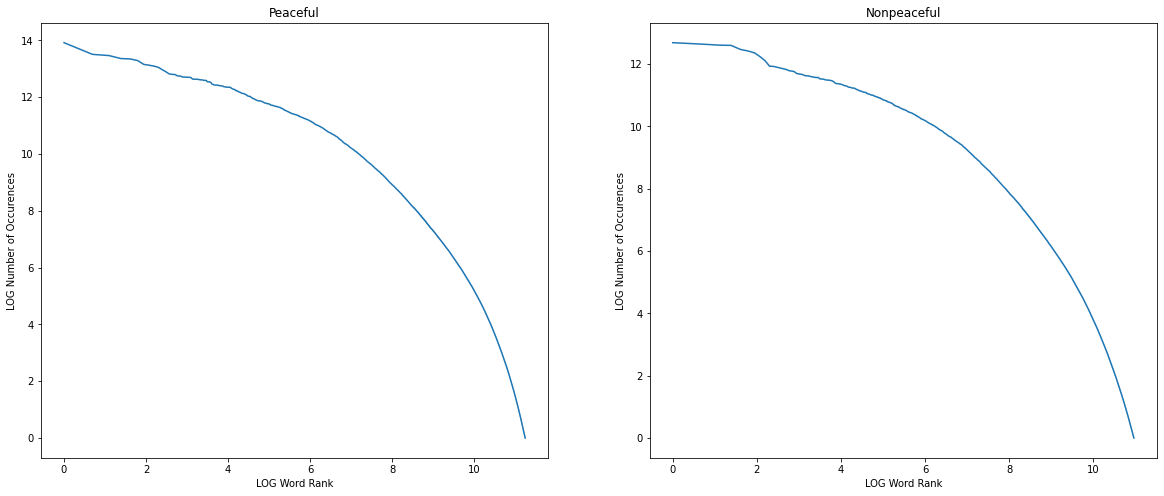

In [10]:
%%time

def plot_zipfs(wf, society, ax=None):

    df = wf[wf.society == society].copy()
    df = df.sort_values(by=["freq"], ascending=False)

    x = np.log(df.freq_rank.values)
    y = np.log(df.freq.values)

    ax = sns.lineplot(x, y, ax=ax)
    ax.set_xlabel("LOG Word Rank")
    ax.set_ylabel("LOG Number of Occurences")
    ax.set_title(society)
    
fig, axes = plt.subplots(ncols=2, figsize=(20, 8))

plot_zipfs(apply_rankings(word_freqs), "Peaceful", axes[0])
plot_zipfs(apply_rankings(word_freqs), "Nonpeaceful", axes[1])

In [57]:
def get_top_n(top_n):
    peaceful_words = set(top_n[top_n.society == "Peaceful"].word.tolist())
    nonpeaceful_words = set(top_n[top_n.society == "Nonpeaceful"].word.tolist())

    common_words = set.intersection(peaceful_words, nonpeaceful_words)
    
    return peaceful_words - common_words, nonpeaceful_words - common_words


def get_rank_comparison(top_n):
    def get_higher_rank(x):
        p, n = x["Peaceful"], x["Nonpeaceful"]
        if p > n:
            return "Nonpeaceful"
        elif n > p:
            return "Peaceful"
        else:
            return pd.NA
    rank_comparison = top_n[["society", "word", "freq_rank"]].copy()
    rank_comparison = rank_comparison[rank_comparison.duplicated("word", keep=False)]
    rank_comparison = rank_comparison.pivot(index="word", columns="society", values="freq_rank").reset_index()
    rank_comparison["abs_diff_rank"] = np.abs(rank_comparison.Nonpeaceful - rank_comparison.Peaceful)
    rank_comparison["higher_ranked"] = rank_comparison.apply(get_higher_rank, axis=1)
    
    return rank_comparison.copy()

def get_diff_rank_words(top_n, diff=30):
    rank_comparison = get_rank_comparison(top_n)
    rank_comparison = rank_comparison[rank_comparison.abs_diff_rank >= diff]
    
    words = {g: set(d.word.tolist()) for g, d in rank_comparison.groupby("higher_ranked")}
    
    return words["Peaceful"], words["Nonpeaceful"]

def print_words(u_peaceful_words, u_nonpeaceful_words, c_peaceful_words, c_nonpeaceful_words, diff=30):
    
    pp = pprint.PrettyPrinter(width=130, compact=True)

    print("**Peaceful Words**")
    print("Unique - ")
    pp.pprint(u_peaceful_words)
    
    print(f"\nHigher Ranked (diff of {diff}+) - ")
    pp.pprint(c_peaceful_words)

    print("\n\n**Non Peaceful Words**")
    print("Unique - ")
    pp.pprint(u_nonpeaceful_words)
    
    print(f"\nHigher Ranked (diff of {diff}+) - ")
    pp.pprint(c_nonpeaceful_words)
    
def run_words(wf, n=100, diff=30, print_words=True):
    df = apply_rankings(wf).copy()
    top_n = df[df["freq_rank"] <= n].copy()
    u_peaceful_words, u_nonpeaceful_words = get_top_n(top_n)
    c_peaceful_words, c_nonpeaceful_words = get_diff_rank_words(top_n, diff)
    
    if print_words:
        print_words(u_peaceful_words, u_nonpeaceful_words, c_peaceful_words, c_nonpeaceful_words, diff)
        
    return u_peaceful_words, u_nonpeaceful_words, c_peaceful_words, c_nonpeaceful_words

In [51]:
word_freqs.to_csv("data/word_frequencies.csv", index=False)

In [52]:
_ = run_words(word_freqs)

**Peaceful Words**
Unique - 
{'another', 'around', 'base', 'best', 'cent', 'change', 'city', 'community', 'continue', 'every', 'family', 'five', 'four',
 'game', 'great', 'health', 'home', 'keep', 'leave', 'live', 'long', 'move', 'much', 'next', 'open', 'plan', 'play', 'player',
 'point', 'really', 'season', 'second', 'thing', 'think', 'week'}

Higher Ranked (diff of 30+) - 
{'look', 'still', 'help', 'back', 'month', 'team', 'find', 'show'}


**Non Peaceful Words**
Unique - 
{'accord', 'bank', 'billion', 'chief', 'court', 'development', 'election', 'general', 'governor', 'hold', 'house', 'however',
 'increase', 'international', 'kenya', 'leader', 'local', 'medium', 'minister', 'must', 'nation', 'nigeria', 'nigerian',
 'official', 'order', 'pakistan', 'party', 'political', 'power', 'president', 'project', 'recommend', 'sector', 'security',
 'university'}

Higher Ranked (diff of 30+) - 
{'state', 'country', 'police', 'member', 'issue', 'case', 'area', 'national', 'million'}


In [53]:
_ = run_words(word_freqs.query("n_synnouns == 0"), 250)

**Peaceful Words**
Unique - 
{'absolutely', 'alongside', 'beautiful', 'certainly', 'cheap', 'clearly', 'compete', 'completely', 'connect', 'dangerous',
 'defend', 'definitely', 'directly', 'easily', 'eventually', 'exactly', 'excite', 'extremely', 'famous', 'guilty', 'healthy',
 'heard', 'imagine', 'inspire', 'intend', 'interested', 'listen', 'maybe', 'mental', 'obviously', 'physical', 'powerful',
 'pretty', 'previously', 'probably', 'proud', 'quickly', 'realise', 'recognise', 'reflect', 'related', 'replace', 'sexual',
 'slow', 'southern', 'survive', 'twice', 'unique', 'warm', 'wide'}

Higher Ranked (diff of 30+) - 
{'actually', 'admit', 'almost', 'appear', 'apply', 'arrive', 'aware', 'certain', 'choose', 'contain', 'digital', 'discover',
 'easy', 'either', 'enter', 'environmental', 'ever', 'finally', 'happy', 'hard', 'hear', 'highly', 'likely', 'massive', 'near',
 'nearly', 'occur', 'often', 'online', 'perhaps', 'popular', 'prove', 'publish', 'quite', 'rather', 'really', 'remember', 's

In [55]:
_ = run_words(word_freqs.query("n_synverbs > 1"), 250)

**Peaceful Words**
Unique - 
{'chance', 'coach', 'couple', 'cover', 'design', 'drop', 'drug', 'fall', 'feature', 'figure', 'finish', 'front', 'hear', 'image',
 'light', 'miss', 'model', 'park', 'pick', 'picture', 'program', 'race', 'range', 'review', 'round', 'save', 'score', 'short',
 'spend', 'stage', 'store', 'suggest', 'track', 'travel', 'trump', 'wait', 'walk', 'watch'}

Higher Ranked (diff of 30+) - 
{'appear', 'book', 'break', 'build', 'building', 'care', 'centre', 'close', 'club', 'comment', 'consider', 'course', 'date',
 'deal', 'drive', 'experience', 'feel', 'film', 'fire', 'focus', 'full', 'happen', 'home', 'impact', 'involve', 'keep', 'learn',
 'line', 'look', 'love', 'mark', 'mean', 'offer', 'open', 'play', 'research', 'rise', 'risk', 'season', 'seem', 'sport', 'staff',
 'star', 'stay', 'study', 'test', 'think', 'turn', 'write'}


**Non Peaceful Words**
Unique - 
{'accuse', 'address', 'affect', 'agree', 'amount', 'appeal', 'arrest', 'commission', 'conduct', 'direct', 'esta

In [89]:
up1, un1, cp1, cn1 = run_words(word_freqs.query("n_synnouns == 0"), 300, print_words=False)
up2, un2, cp2, cn2 = run_words(word_freqs.query("n_synverbs > 1"), 300, print_words=False)

new_lexicon = []
for label, words in zip(["peace", "conflict", "peace", "conflict"] * 2, [up1, un1, cp1, cn1, up2, un2, cp2, cn2]):
    lexicon_df = pd.DataFrame({"term": list(words)}, index=range(len(words)))
    lexicon_df["lexicon"] = label
    new_lexicon.append(lexicon_df)
    
new_lexicon = pd.concat(new_lexicon).reset_index(drop=True)
new_lexicon = new_lexicon.drop_duplicates(["term", "lexicon"])

new_lexicon.to_csv("lexicons/top_words_lexicon.csv", index=False)

In [94]:
print(new_lexicon.shape)
new_lexicon.head()

(414, 2)


,term,lexicon
0,imagine,peace
1,busy,peace
2,pretty,peace
3,initially,peace
4,acknowledge,peace
